In [61]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39589 sha256=2d8d3f31fab86281f0240c3b9ee7475da544b0d9cc1b7d1e4638d12bd3c0b01a
  Stored in directory: /home/jovyan/.cache/pip/wheels/8b/0d/d2/b12bec1ccc028921fb98158042ade2d19dae73925dfc636954
Successfully built grad-cam


In [62]:
import torch
import torchvision
import numpy as np
import csv
import os
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [114]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):

    def __getitem__(self, index):
  
        img, label = super(ImageFolderWithPaths, self).__getitem__(index)
        
        path = self.imgs[index][0]
        
        return (img, label ,path)


def get_cxr_eval_transforms(crop_size,normalise):
    cxr_transform_list = [
        v2.ToImage(),
        v2.Resize(size=crop_size,antialias=True),
        v2.ToDtype(torch.float32, scale=False),
        normalise
    ]
    return cxr_transform_list

def read_bounding_boxes(bbox_csv_path):
    """Read the bounding box CSV file and return a dictionary with image names as keys and bounding boxes as values."""
    bbox_dict = {}

    with open(bbox_csv_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            img_name = row['img_name']
            bbox_224 = eval(row['bbox_224'])  # Convert string to a list (e.g., "[32, 119, 15, 13]" -> [32, 119, 15, 13])
            bbox_dict[img_name] = bbox_224  # Store the bounding box (x, y, width, height)
    
    return bbox_dict

def calculate_iou(cam_mask, bounding_boxes):
    """Calculate IoU between CAM mask and ground-truth bounding boxes."""
    # cam_mask = (cam_mask > 0.5).float()  # Binary mask
    ious = []
    for i in range(cam_mask.shape[0]):#range(cam_mask.size(0)):
        box = bounding_boxes[i]  # Get ground-truth box (xmin, ymin, xmax, ymax)
        cam_region = cam_mask[i].nonzero()  # Get CAM region
        
        if cam_region.size(0) == 0:  # If no region, IoU is 0
            ious.append(0.0)
            continue
        
        # Create a mask for the bounding box
        box_mask = torch.zeros_like(cam_mask[i])
        box_mask[box[1]:box[3], box[0]:box[2]] = 1.0

        # Calculate intersection and union between CAM region and ground-truth box
        intersection = (cam_mask[i] * box_mask).sum()
        union = (cam_mask[i] + box_mask).clamp(0, 1).sum()

        iou = intersection / union
        ious.append(iou.item())

    return ious

crop_dict = {
    # data      mean         std
    'cxr14': [[162.7414], [44.0700]],
    'openi': [[157.6150], [41.8371]],
    'jsrt': [[161.7889], [41.3950]],
    'padchest': [[160.3638], [44.8449]],
}

In [7]:
from torchvision.transforms import v2

In [50]:
data_root = "/home/local/data/sophie"
train_set = "jsrt"
process = "crop"
std_dir = "std_1024"
crop_size = 224
test_path = os.path.join(data_root, train_set, process, std_dir, "test")
train_path = os.path.join(data_root, train_set, process, std_dir, "train")

normalise = torchvision.transforms.v2.Normalize(mean=[161.7889], std=[41.3950])
test_transform = get_cxr_eval_transforms(crop_size, normalise)

In [51]:
def remap_labels(label):
    # mapping_dict = {'normal': 0, 'nodule': 1}
    mapping_dict = {trainset.class_to_idx['nodule']: 1, trainset.class_to_idx['normal']: 0}
    return mapping_dict[label]

In [52]:
trainset = ImageFolderWithPaths(root=train_path, transform=v2.Compose(test_transform), target_transform=remap_labels)
testset = ImageFolderWithPaths(root=test_path, transform=v2.Compose(test_transform), target_transform=remap_labels)
# testset.class_to_idx = {'normal': 0,'nodule': 1}
# testset2.class_to_idx = {'normal': 0, 'nodule': 1}

trainloader = torch.utils.data.DataLoader(trainset, batch_size=6, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=6, shuffle=False)

In [63]:
for data in testloader:
    inputs, labels = data[0], data[1]
    img_paths = np.array(data[2])
    if labels.any() == 1:
        break
        

In [64]:
nodule_mask = labels == 1
nodule_mask

tensor([True, True, True, True, True, True])

In [65]:
if nodule_mask.sum() > 0: 
    nodule_inputs = inputs[nodule_mask].requires_grad_(True)
    nodule_img_paths = [os.path.basename(img_path).split('.')[0] for img_path in img_paths[nodule_mask]]
    targets = [ClassifierOutputTarget(1)]
    # grayscale_cam = cam(input_tensor=nodule_inputs, targets=targets)

In [88]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

# model = resnet50(pretrained=True)
model = torchvision.models.resnet50(pretrained=True)
weights = torch.load("/home/local/data/sophie/model_89.pth", map_location='cpu')
new_state_dict = {}
for k, v in weights['model'].items():
    k = k.replace("module.", "")
    new_state_dict[k] = v
model.load_state_dict(new_state_dict)
num_classes = 2
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)

model.eval()
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)


with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0], data[1]
        img_paths = np.array(data[2])
        if labels.any() == 1:
            break
            # outputs = model(inputs)

In [89]:
outputs = model(inputs)
probs = torch.softmax(outputs, dim=1)[:, 1]
preds = torch.argmax(outputs, dim=1)
true_labels = labels.cpu().detach().numpy()
pred_labels = preds.cpu().detach().numpy()
pred_probs = probs.cpu().detach().numpy()

In [90]:
nodule_mask = labels == 1
if nodule_mask.sum() > 0:
    nodule_inputs = inputs[nodule_mask]
    with torch.set_grad_enabled(True):
        model.train()
        nodule_inputs = nodule_inputs.requires_grad_()
        nodule_img_paths = [os.path.basename(img_path).split('.')[0] for img_path in img_paths[nodule_mask.cpu()]]
        targets = [ClassifierOutputTarget(1)]
        grayscale_cam = cam(input_tensor=nodule_inputs, targets=targets)
    model.eval()

In [92]:
cam_mask = (grayscale_cam > 0.5).astype(float)

In [95]:
bbox_test = read_bounding_boxes(
    os.path.join(data_root,
                 train_set,
                 "{}_{}_bboxes.csv".format(
                     "jsrt","test")))

In [100]:
nodule_img_paths

['n0019', 'n0029', 'n0068', 'n0070', 'n0071', 'n0085']

In [107]:
[bbox_test[d] for d in nodule_img_paths][0]

[188, 127, 17, 18]

In [109]:
batch_bboxes = [bbox_test[d] for d in nodule_img_paths]

In [110]:
batch_bboxes

[[188, 127, 17, 18],
 [41, 37, 10, 10],
 [39, 45, 12, 12],
 [44, 54, 15, 14],
 [52, 179, 28, 29],
 [198, 167, 17, 17]]

In [102]:
bbox_test['n0019']

[188, 127, 17, 18]

In [113]:
cam_mask.shape[0]

6

In [146]:
cam_mask[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [151]:
torch.tensor(cam_mask[0]).shape

torch.Size([224, 224])

In [152]:
torch.tensor(cam_mask[0]).nonzero()

tensor([[ 38,  77],
        [ 38,  78],
        [ 38,  79],
        ...,
        [125,  48],
        [125,  49],
        [125,  50]])

In [153]:
torch.tensor(cam_mask[0]).nonzero().size(0)

3634

In [154]:
box_mask = torch.zeros_like(torch.tensor(cam_mask[0]))

In [162]:
box_mask

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [155]:
box_mask[box[1]:box[3], box[0]:box[2]] = 1.0

In [158]:
intersection = (torch.tensor(cam_mask[0]) * box_mask).sum()

In [159]:
union = (torch.tensor(cam_mask[0]) + box_mask).clamp(0, 1).sum()

In [160]:
iou = intersection / union

In [161]:
iou

tensor(0., dtype=torch.float64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


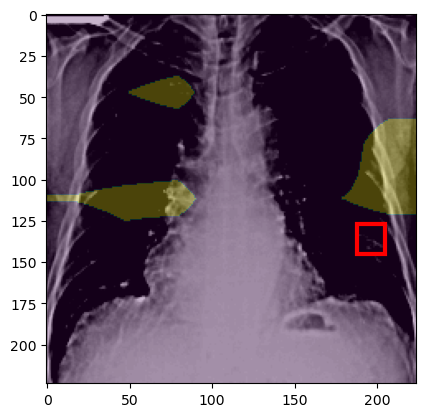

In [168]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.imshow(np.transpose(nodule_inputs[0].detach().numpy(),(1,2,0)))
plt.imshow(torch.tensor(cam_mask[0]),alpha=0.3)
plt.gca().add_patch(Rectangle((batch_bboxes[0][0],batch_bboxes[0][1]),
                              batch_bboxes[0][2],batch_bboxes[0][3],
                    edgecolor='red',
                    facecolor='none',
                    lw=3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


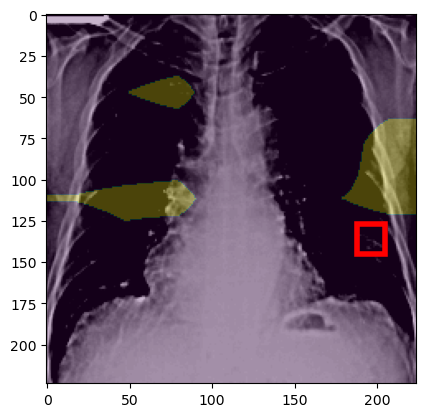

In [157]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.imshow(np.transpose(nodule_inputs[0].detach().numpy(),(1,2,0)))
# for masssk in cam_mask[0].nonzero():
#     plt.imshow(masssk,alpha=0.3)
plt.imshow(cam_mask[0],alpha=0.3)
plt.gca().add_patch(Rectangle((batch_bboxes[0][0],batch_bboxes[0][1]),
                              batch_bboxes[0][2],batch_bboxes[0][3],
                    edgecolor='red',
                    facecolor='none',
                    lw=4))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


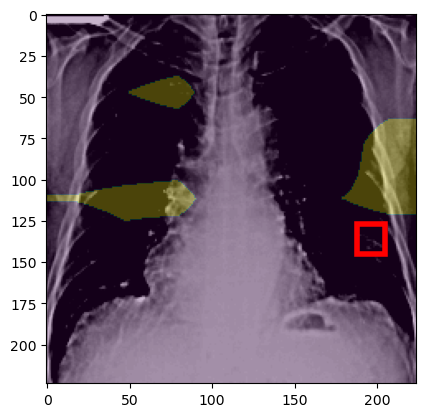

In [141]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.imshow(np.transpose(nodule_inputs[0].detach().numpy(),(1,2,0)))
plt.imshow(cam_mask[0],alpha=0.3)
plt.gca().add_patch(Rectangle((batch_bboxes[0][0],batch_bboxes[0][1]),
                              batch_bboxes[0][2],batch_bboxes[0][3],
                    edgecolor='red',
                    facecolor='none',
                    lw=4))

In [118]:
ious = []
for i in range(cam_mask.shape[0]):#range(cam_mask.size(0)):
    box = batch_bboxes[i]  # Get ground-truth box (xmin, ymin, xmax, ymax)
    cam_region = cam_mask[i].nonzero()  # Get CAM region
    
    if cam_region.shape[0] == 0:  # If no region, IoU is 0
        ious.append(0.0)
        continue
    
    # Create a mask for the bounding box
    box_mask = torch.zeros_like(cam_mask[i])
    box_mask[box[1]:box[3], box[0]:box[2]] = 1.0

    # Calculate intersection and union between CAM region and ground-truth box
    intersection = (cam_mask[i] * box_mask).sum()
    union = (cam_mask[i] + box_mask).clamp(0, 1).sum()

    iou = intersection / union
    ious.append(iou.item())

AttributeError: 'tuple' object has no attribute 'size'

In [115]:
iou_batch = calculate_iou(cam_mask, batch_bboxes)

AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
target_layers = [model.layer4[-1]]
input_tensor = # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(281)]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs